In [20]:
import pickle
import warnings
import random
import umap
import torch

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict
from scipy.spatial import distance
from scipy import stats
from sklearn import decomposition

from torch.nn import functional as F

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [22]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 200

In [24]:
embeds, rows = [], []

for path in tqdm(glob('../../data/clean-embeds/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            title = ' '.join(line.pop('tokens'))
            embeds.append(line.pop('embedding'))
            rows.append(OrderedDict(title=title, **line))

100%|██████████| 66/66 [00:23<00:00,  2.82it/s]


In [26]:
embeds = np.stack(embeds)

In [27]:
df = pd.DataFrame(rows)

In [28]:
df.label.unique()

array(['dailycaller.com', 'bloomberg.com', 'thehill.com',
       'huffingtonpost.com', 'dailykos.com', 'nytimes.com', 'cnn.com',
       'wsj.com', 'apnews.com', 'breitbart.com', 'foxnews.com',
       'washingtonpost.com', 'buzzfeed.com'], dtype=object)

In [29]:
embeds.shape

(651589, 512)

In [30]:
def ds_from_mean(d):
    
    d_embeds = embeds[df[df.label==d].index]
    
    mean = d_embeds.mean(0)
    means = np.tile(mean, (len(d_embeds), 1))
    
    x1 = torch.from_numpy(d_embeds)
    x2 = torch.from_numpy(means)
    
    ds = F.cosine_similarity(x1, x2)
    
    return ds.numpy()

In [31]:
domains = df.label.unique()

In [32]:
ds = {
    d: ds_from_mean(d)
    for d in tqdm(domains)
}

100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


dailycaller.com


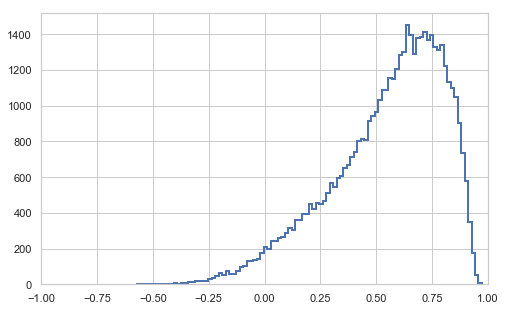

bloomberg.com


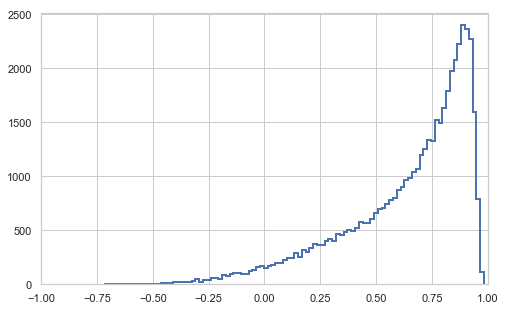

thehill.com


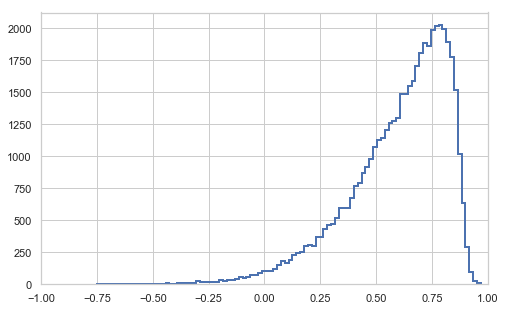

huffingtonpost.com


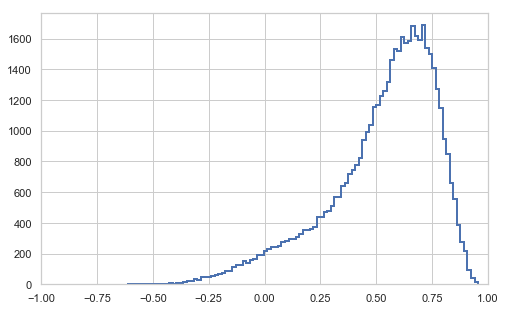

dailykos.com


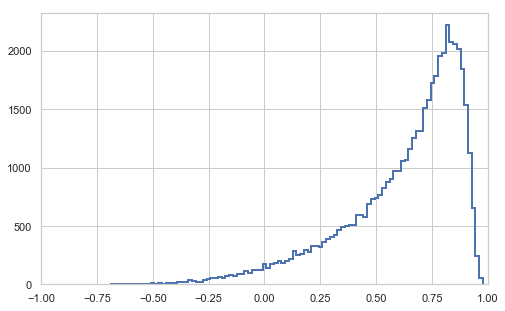

nytimes.com


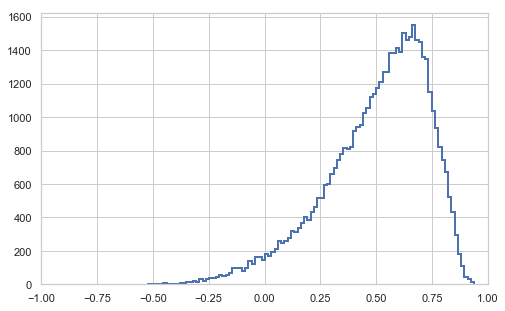

cnn.com


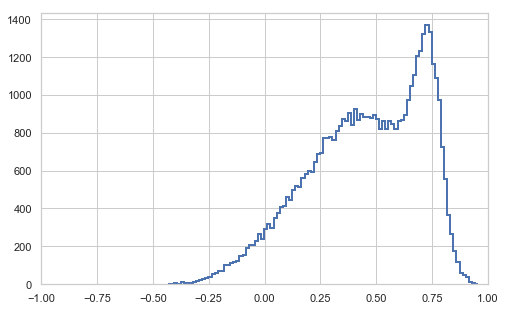

wsj.com


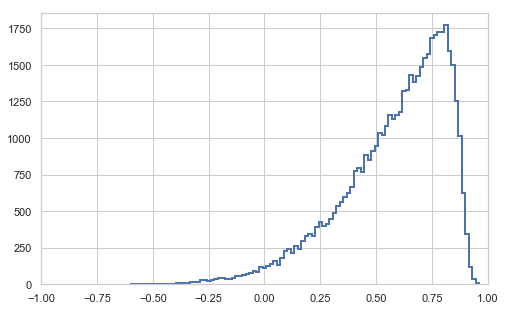

apnews.com


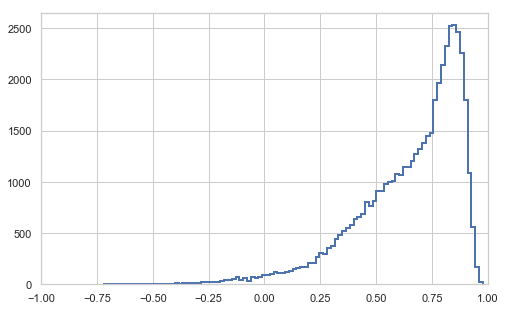

breitbart.com


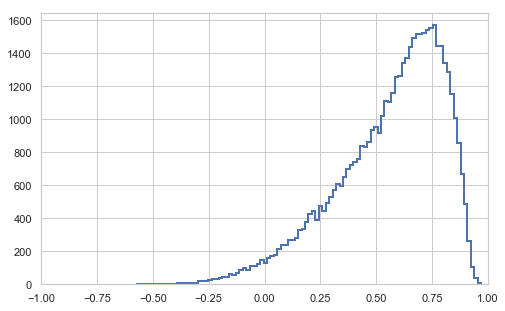

foxnews.com


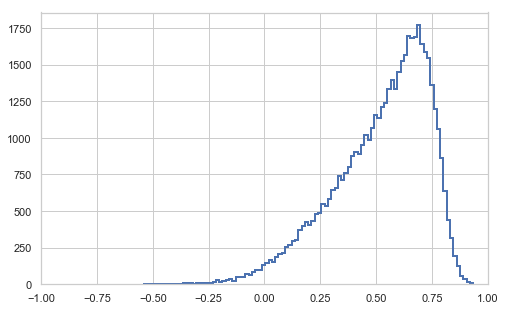

washingtonpost.com


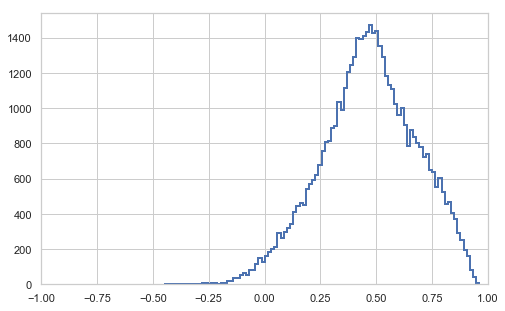

buzzfeed.com


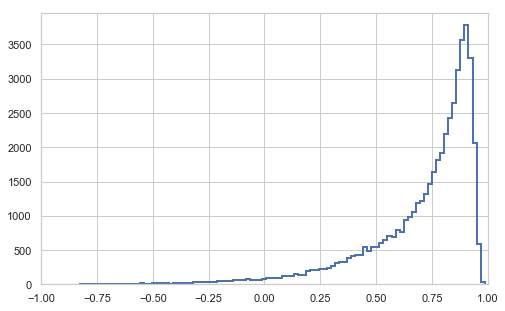

In [33]:
for domain in ds:
    print(domain)
    plt.figure(figsize=(8,5))
    plt.xlim(-1, 1)
    ys, x, _ = plt.hist(ds[domain], histtype='step', bins=100, linewidth=2)
    plt.show()

In [34]:
def plot_ds_violin(ds):

    rows = []
    for domain, dds in ds.items():
        for d in dds:
            rows.append((domain, d))
            
    ds_df = pd.DataFrame(rows, columns=('domain', 'd'))
    
    order = ds_df.groupby('domain').mean().sort_values('d', ascending=False).index
    plt.figure(figsize=(5,10))
    sns.violinplot(y='domain', x='d', data=ds_df.sample(frac=0.01), order=order)

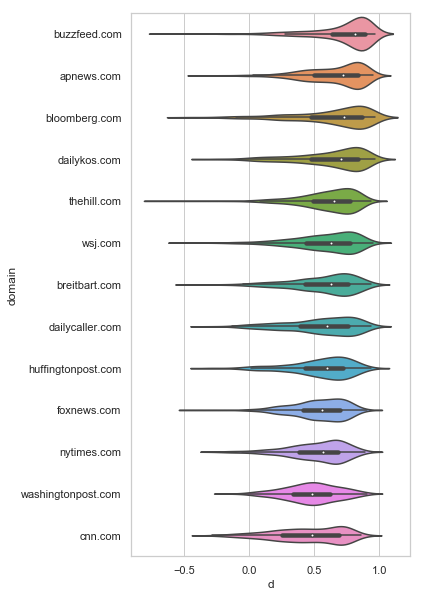

In [35]:
plot_ds_violin(ds)